The aim of this notebook is to test BO in real-life experimental data (compressed by PCA already)

One of the (highest) observed result is first removed from the dataset. 
A standard BO will be performed based on the rest of data. 
The predicted next-point-to-go will be compared with the left-out-best point.
The previous left-out point will be then added to the training set to refine the model. 


In [69]:
import pandas as pd
import numpy as np
seed = 95
np.random.seed(seed)

import matplotlib.pyplot as plt

from sklearn.gaussian_process import GaussianProcessRegressor as GPR

from sklearn.gaussian_process.kernels import WhiteKernel, RBF, Matern

from scipy.optimize import minimize

In [2]:
data_file = "bo_test_pca_df_mono_24.csv"

In [4]:
origin_data = pd.read_csv(data_file, index_col = None)
origin_data.head()

,Unnamed: 0,PC1,PC2,standardised_yield,yield
0,0,2.993404,1.292484,1.498429,0.82
1,1,-0.088412,-1.644992,1.081716,0.72
2,2,7.073370,1.667592,0.998374,0.70
3,3,4.542111,2.017177,0.665004,0.62
4,4,3.072163,-1.591613,0.248291,0.52


In [8]:
train_df = pd.DataFrame()
train_df['X1'] = origin_data['PC1']
train_df['X2'] = origin_data['PC2']
train_df['Y'] = origin_data['standardised_yield']
train_df.head()

,X1,X2,Y
0,2.993404,1.292484,1.498429
1,-0.088412,-1.644992,1.081716
2,7.073370,1.667592,0.998374
3,4.542111,2.017177,0.665004
4,3.072163,-1.591613,0.248291


In [11]:
#sort values by std yield
train_df.sort_values(by = 'Y', ascending = False)
train_df.head()

,X1,X2,Y
0,2.993404,1.292484,1.498429
1,-0.088412,-1.644992,1.081716
2,7.073370,1.667592,0.998374
3,4.542111,2.017177,0.665004
4,3.072163,-1.591613,0.248291


In [12]:
#split the full dataset with highest Y and the rest
real_best_Y = train_df.iloc[0]
rest_train_df = train_df.iloc[1:]

In [17]:
#the best observed data, separate from the training set
real_best_Y

X1    2.993404
X2    1.292484
Y     1.498429
Name: 0, dtype: float64

In [19]:
#the rest of the training set, to be fed in to BO
rest_train_df.head()

,X1,X2,Y
1,-0.088412,-1.644992,1.081716
2,7.073370,1.667592,0.998374
3,4.542111,2.017177,0.665004
4,3.072163,-1.591613,0.248291
5,-2.375972,6.346179,-0.835161


In [25]:
all_col = rest_train_df.columns

In [31]:
#since this is a more-than-one-dimensional data, we need to first weight each X by the correlation with Y

def get_all_corr(all_col, ip_df):
    corr_dict = {
        'X':[],
        'corr_X_Y':[]
    }

    for x in all_col[:-1]:
        
#         print(x)
        corr_dict['X'].append(x)
        corr_x_Y = rest_train_df[x].corr(rest_train_df['Y'])
        corr_dict['corr_X_Y'].append(corr_x_Y)
#         print(corr_1)
    return corr_dict


In [32]:
get_all_corr(all_col, rest_train_df)

{'X': ['X1', 'X2'], 'corr_X_Y': [0.6807575882726294, -0.15811810254336017]}

In [33]:
#the result indicates X1 has 0.68 correlation with Y
#X2 has -0.15 correlation with Y

In [36]:
#combine all variables (in this case is 2) into one variable

def dim_to_one(all_col, ip_df):
    corr_dict = get_all_corr(all_col, ip_df)
    #initialise the combined X column
    op_df = ip_df
    op_df['comb_X'] = 0
    for i, x in enumerate(corr_dict['X']):
        op_df['comb_X'] += op_df[corr_dict['X'][i]]*corr_dict['corr_X_Y'][i] #calculate the weighted variable
    return op_df

In [37]:
rest_train_df_one_dim = dim_to_one(all_col, rest_train_df)

C:\Users\sh19129\AppData\Local\Temp\ipykernel_2772\3632373965.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  op_df['comb_X'] = 0
C:\Users\sh19129\AppData\Local\Temp\ipykernel_2772\3632373965.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  op_df['comb_X'] += op_df[corr_dict['X'][i]]*corr_dict['corr_X_Y'][i] #calculate the weighted variable


In [39]:
rest_train_df_one_dim.head()

,X1,X2,Y,comb_X
1,-0.088412,-1.644992,1.081716,0.199916
2,7.073370,1.667592,0.998374,4.551574
3,4.542111,2.017177,0.665004,2.773125
4,3.072163,-1.591613,0.248291,2.343061
5,-2.375972,6.346179,-0.835161,-2.620907


In [161]:
highest_df_one_dim = dim_to_one(all_col, real_best_Y)
highest_df_one_dim #with combined x based on the observed best value
obs_best_x = highest_df_one_dim['comb_X']
obs_best_y = highest_df_one_dim['Y']
print(obs_best_x, obs_best_y)

1.8334173281690633 1.4984287460757888


C:\Users\sh19129\AppData\Local\Temp\ipykernel_2772\3632373965.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  op_df['comb_X'] = 0
C:\Users\sh19129\AppData\Local\Temp\ipykernel_2772\3632373965.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  op_df['comb_X'] += op_df[corr_dict['X'][i]]*corr_dict['corr_X_Y'][i] #calculate the weighted variable


In [40]:
#organise the one-dimensional data (to be fed into BO)

def sort_data_for_BO(ip_df):
    exp_X_Y = pd.DataFrame()
    exp_X_Y['X'] = ip_df['comb_X']
    exp_X_Y['Y'] = ip_df['Y']
    return exp_X_Y


In [41]:
data_for_BO = sort_data_for_BO(rest_train_df_one_dim)
data_for_BO.head()

,X,Y
1,0.199916,1.081716
2,4.551574,0.998374
3,2.773125,0.665004
4,2.343061,0.248291
5,-2.620907,-0.835161


In [198]:
#user inputs and pre-define hyperparameters for BO

noise_level = 0.5 #the expected standard deviation of experimental measurement

#hyperparameters for rbf
rbf_hp = {
    'length_scale': 1,
    'length_scale_bounds' : (1e-4, 1e4),
    'amp' : 1,
    'const' : 0
}

# kernel = rbf_hp['amp']*RBF(length_scale = rbf_hp['length_scale'], length_scale_bounds = rbf_hp['length_scale_bounds']) + rbf_hp['const']

matern_hp = {
    'length_scale': 1,
    'length_scale_bounds' : (1e-4, 1e2),
    'nu' : 1.5,
    'amp':1,
    'const' : 0
}

kernel = matern_hp['amp']*Matern(length_scale = matern_hp['length_scale'], length_scale_bounds = matern_hp['length_scale_bounds'], nu = matern_hp['nu'])+matern_hp['const']


#hyperparameters and kernel dictionary
gpr_hp_dict = {
    'alpha' : noise_level,
    'kernel' : kernel,
    'random_state' : 1
}

#generate the initial X
X = np.linspace(-5, 5, 201) #Generate 201 initial points from -10 to 10

#generate real_X and real_Y for the first round
#convert the pandas series to nparray
real_X = np.asarray(data_for_BO['X'])
real_Y = np.asarray(-data_for_BO['Y'])#here all the Y are opposite to the original because the BO is going to minimise the data

In [189]:
def modify_hp(gpr_hp_dict, noise_level, length_scale, length_scale_bounds, kern = 'matern', nu = 1.5, amp = 1, const = 0):
    if kern == 'matern':
        kernel = amp*Matern(length_scale =length_scale, length_scale_bounds = length_scale_bounds, nu = nu)+ const
        
    gpr_hp_dict['kernel'] = kernel
    gpr_hp_dict['alpha'] = noise_level
    return gpr_hp_dict

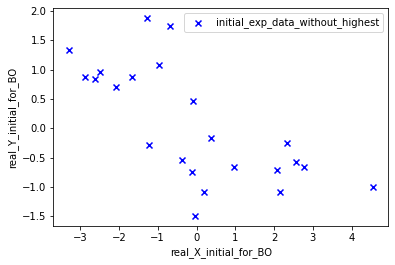

In [199]:
#look at the initial measurements
fig, ax = plt.subplots()
# ax.plot(X, Y, color = 'red', label = 'theoretical')
ax.scatter(real_X, real_Y, color = 'blue', marker = 'x', label = 'initial_exp_data_without_highest')
ax.set_xlabel('real_X_initial_for_BO')
ax.set_ylabel('real_Y_initial_for_BO')
ax.legend()


In [200]:
def convert_dim(X):
    """
    The dimension of X must be 2.
    If X is a 1D array, reshape it to 2.
    Otherwise raise error.
    
    The first index is the number of sample.
    The second index is the number of dimension.
    There should not be any more dimension.
    """
    if not isinstance(X, np.ndarray):
        if isinstance(X, list):
            X = convert_dim(np.array(X))
        elif isinstance(X, (int, float, complex)):
            X = convert_dim(np.array([X]))
            
    
    if len(X.shape) == 1:
        return X.reshape(-1, 1)
    elif len(X.shape) == 2:
        return X
    else:
        raise ValueError(f"The shape of X: {len(X.shape)}, is larger than 2.")


def convert_type_y(Y):
    if not isinstance(Y, np.ndarray):
        if isinstance(Y, list):
            Y = np.array(Y)
        elif isinstance(Y, (int, float, complex)):
            Y = np.array([Y])
        
    
    return Y

In [201]:
class BayesOpt:
    
    def __init__(self):
        self.data_X = [] # initialise the data container
        self.data_Y = []
        self.gpr_log = {}
        
    
    def load_data(self, X:np.ndarray, Y:np.ndarray):
        """
        Load real measurement data
        """
        #get the right shape, 2d array
        reshp_X = convert_dim(X)
        
        self.data_X = reshp_X
        self.data_Y = convert_type_y(Y)
        
#         print(self.data_X)
#         print(self.data_Y)
    
    def do_gpr(self, gpr_hp:dict):
        """
        run gaussian progress regression.
        The hyperparameters are pre-defined by users in gpr_hp.
        The model will auto refine itself based on the data fed into it.
        """
        kernel = gpr_hp['kernel']
        random_state = gpr_hp['random_state']
        alpha = gpr_hp['alpha'] #the noise level
        
        #check if data has been properly loaded. Abort if not.
        if len(self.data_X) != 0:
            gpr = GPR(kernel = kernel, alpha = alpha, random_state = random_state).fit(self.data_X, self.data_Y)
            self.gpr_log['gpr'] = gpr
        
        else:
            raise ValueError("No data has been loaded. Please load initial measurement data.")
        
        #results
        new_kernel = gpr.kernel_ #return kernel after training
        gpr_score = gpr.score(self.data_X, self.data_Y) #return fitting score
        
        self.gpr_log['opt_kernel']  = new_kernel
        self.gpr_log['score'] = gpr_score
        
        print(f"gpr log: {self.gpr_log}")
        print("Look out for warning message. If says convergence failed, please modify the gpr_hp_dict inputs")
    
    def gpr_predict(self, X_to_predict, return_std = True, get_plot = True):
        
        self.reshp_X_to_predict = convert_dim(X_to_predict) #the X series to predict, needs to be reshaped before feeding into gpr
        
        self.X_to_pred_for_plot = X_to_predict #the X series to plot
        
        self.y_pred_mean, self.y_pred_std = self.gpr_log['gpr'].predict(self.reshp_X_to_predict, return_std = True) #prediction
        
        if get_plot:
            self.plot_gpr_results() #optional

        
    def plot_gpr_results(self, aq_func = None):
        """
        This step is the one to give you the transparent fillings behind the curve.
        Also the iconic styles seen in BO related papers.
        However, if you try to run the workflow again, this confidence interval part could change.
        There are many random factors involved there...
        """
        fig, ax = plt.subplots()
#         ax.plot(self.reshp_X_to_predict, Y, color = 'red', ls = '--', label = 'theoretical')
        ax.errorbar(self.data_X, self.data_Y, yerr = noise_level, color = 'black', ls = 'None', marker = '.', label = 'experimental')
        #yerr is the noise_level used above
        ax.plot(self.X_to_pred_for_plot, self.y_pred_mean, color = 'tab:orange', label = 'predicted mean')
        ax.fill_between(self.X_to_pred_for_plot, self.y_pred_mean-self.y_pred_std*1.96, self.y_pred_mean+self.y_pred_std*1.96, alpha = 0.5, color = 'tab:orange', label = '95% confidence level')
        #1.96 on std is to plot 95% confidence interval
        
        if aq_func is not None:
            ax.plot(self.X_to_pred_for_plot, self.aq_func_Y, color = 'blue', ls = '--', label = 'aq_func')
            
        ax.legend()
        
        
    def aq_func(self, x0, option = 'ucb', get_aq_plot = True, **kwargs):
        """
        choose which aq_func to use, default ucb.
        Other three tb explored...
        x0 is the initial guess for the prediction to start with.
        """
        
#         kwargs['ucb_beta'] = 1.96
        if option == 'ucb':
            ucb_beta = kwargs['ucb_beta'] if 'ucb_beta' in kwargs else 1.96
            print("UCB starts...")
            res = minimize(self.aq_func_ucb, x0 = x0, args = (ucb_beta, self.gpr_log['gpr']), tol = 1e-2) #this is one step of BO
            self.min_success = res.success
            self.next_x = res.x
            
            self.aq_func_Y = self.aq_func_ucb(self.X_to_pred_for_plot, ucb_beta, self.gpr_log['gpr'])
            if get_aq_plot:
                self.plot_gpr_results(aq_func = 'ucb')

        print(f"success?: {self.min_success}")
        
        if self.min_success is True:
            print(f"Recommended next x to go: {self.next_x}")
        else:
            print("Failed to predict. Please check results status:")
            print(res)

    
    def aq_func_ucb(self, x, ucb_beta, gpr):
        mean, std = gpr.predict(convert_dim(x), return_std = True)
        return  mean - ucb_beta*std
    
    def add_new_data(self, new_x, new_y):
        """
        Users can add new data to training set using this function
        """
        crt_data_x = self.data_X
        crt_data_y = self.data_Y
        
        reshp_new_x = convert_dim(new_x)
        retyp_new_y = convert_type_y(new_y)
        
        #print(reshp_new_x, retyp_new_y)
        
        #concact two arrays together
        concat_data_x = np.concatenate((crt_data_x, reshp_new_x), axis = 0)
        concat_data_y = np.concatenate((crt_data_y, retyp_new_y), axis = 0)
        
        self.data_X = concat_data_x
        self.data_Y = concat_data_y
        
        #print(self.data_X, self.data_Y)
    
    def comp_best_x(self, best_x):
        diff_best_x = best_x - self.next_x[0]
        print(f"Difference from observed best x: {diff_best_x}.")
        perct_error = diff_best_x/self.next_x[0]
        print(f"With error: {perct_error*100}%.")
    

C:\Users\sh19129\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:285: RuntimeWarning: divide by zero encountered in log
  return np.log(np.hstack(theta))
C:\Users\sh19129\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


gpr log: {'gpr': GaussianProcessRegressor(alpha=0.5,
                         kernel=1**2 * Matern(length_scale=1, nu=1.5) + 0**2,
                         random_state=1), 'opt_kernel': 0.777**2 * Matern(length_scale=2.39, nu=1.5) + 0.00316**2, 'score': 0.5923575484063073}
Look out for warning message. If says convergence failed, please modify the gpr_hp_dict inputs
UCB starts...
success?: True
Recommended next x to go: [1.44471585]
Difference from observed best x: 0.3887014806616551.
With error: 26.905047198886074%.


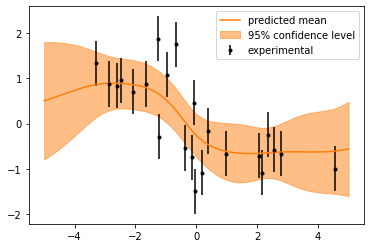

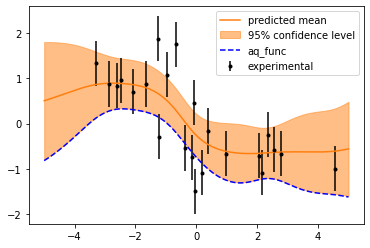

In [202]:
#testblock
#print("real_X, real_Y")
#print(real_X, real_Y)

x0 = 0.5

bo = BayesOpt()
#print("load_data, after dimension conversion:")

#load initial data
bo.load_data(real_X, real_Y)

#first round of gpr
bo.do_gpr(gpr_hp_dict)
bo.gpr_predict(X)
#check the GPR results make sense or not. If yes, please continue with aqusition functions
#Otherwise, modify the gpr_hp_dict inputs

#do prediction for initial guess x0
bo.aq_func(x0, ucb_beta = 2)

#next_x = bo.next_x[0]
bo.comp_best_x(obs_best_x)

gpr log: {'gpr': GaussianProcessRegressor(alpha=0.5,
                         kernel=1**2 * Matern(length_scale=1, nu=1.5) + 0**2,
                         random_state=1), 'opt_kernel': 0.843**2 * Matern(length_scale=2.46, nu=1.5) + 0.00316**2, 'score': 0.6399515168644871}
Look out for warning message. If says convergence failed, please modify the gpr_hp_dict inputs
UCB starts...
success?: True
Recommended next x to go: [1.45720344]
Difference from observed best x: 0.37621388786667365.
With error: 25.817526740713987%.


C:\Users\sh19129\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:285: RuntimeWarning: divide by zero encountered in log
  return np.log(np.hstack(theta))
C:\Users\sh19129\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


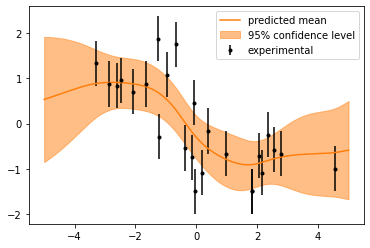

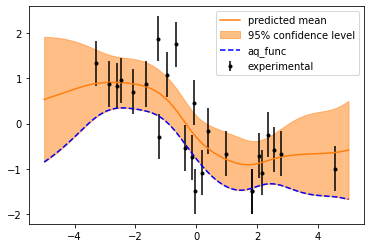

In [204]:
#add new dataset to the prior knowledgebase
#make sure the index in the new_x series match with the new_y series
#For example, np.array([new_x_0, new_x_1, ...]), np.array([new_y_0, new_y_1, ...]) correspond to (new_x_0, new_y_0), (new_x_1, new_y_1), etc.
#here, new_x and new_y can either be numbers or list or array


#add the previous observed best X, Y to the training set
#so as to refine the model
new_x = np.array([obs_best_x])
new_y = -obs_best_y

#the array form
bo.add_new_data(new_x, new_y)

#run gpr + aq_func step again, see what has changed

#if warning says hp needs to be modified
# gpr_hp_dict = modify_hp(gpr_hp_dict, noise_level = 1, length_scale = 1, length_scale_bounds = (1e-4, 1e2), kern = 'matern', nu = 1.5, amp = 1, const = 0)

bo.do_gpr(gpr_hp_dict)
bo.gpr_predict(X)

x0 = obs_best_x+0.1
bo.aq_func(x0, ucb_beta = 1.96)
#It is expected to see more experimental data points in the second figure.
#The model has also been refined. (check gpr_log parameters)
bo.comp_best_x(obs_best_x)

The next point to measure is proposed as 1.45

A step to convert back to the PC space, then the original feature space will be required. 


According to the correlation between X1-Y and X2-Y, X1-Y has a stronger correlation. 

We guess the next X1 to go as the current highest X1 plus 1, i.e., 

In [207]:
train_df.sort_values(by = 'X1', ascending = False)
next_X1 = train_df.iloc[0]['X1'] + 1

We can then revisit the correlation matrix of each variable with Y

In [208]:
all_corr_dict = get_all_corr(all_col, train_df) #this time we don't distinguish the best or not

In [209]:
all_corr_dict

{'X': ['X1', 'X2'], 'corr_X_Y': [0.6807575882726294, -0.15811810254336017]}

In [213]:
next_X2 = ((bo.next_x - all_corr_dict['corr_X_Y'][0]*next_X1)/all_corr_dict['corr_X_Y'][1])[0]

In [216]:
print(f"next X1: {next_X1}")
print(f"next X2: {next_X2}")
#note that next X2 is less important than next X1, due to lower contribution towards the target observable

next X1: 3.993403898202905
next X2: 7.977180007525356
